# **Overview**
 Para resolver esse desafio técnico, irei utilizar o framework **CRISP-DM** para garantir que a análise seja estruturada, repetível e orientada a resultados. Seguindo os passos:

1. Definir o problema de negócio.

2. Coletar os dados e obter uma visão geral deles.

3. Dividir os dados em conjuntos de treino e teste.

4. Explorar os dados (análise exploratória de dados).

5. Engenharia de features, limpeza e pré-processamento dos dados.

6. Treinamento de modelos, comparação, seleção de features e ajuste de hiperparâmetros.

7. Teste e avaliação do modelo final de produção.

8. Concluir e interpretar os resultados do modelo.

9. Deploy do modelo.

### **Importar Bibliotecas**

In [14]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Importing Dataset Splitting, Cross Validation and Grid Search w/ Cross validation libraries
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

# Importing Feature Scalling libraries
from sklearn.preprocessing import StandardScaler, normalize

# Importing Machine Learning Models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Importing Metrics libraries
from sklearn.metrics import confusion_matrix

# Importing Metric Plots libraries
from sklearn.metrics import classification_report

# Importing Balancing libraries
from imblearn.over_sampling import SMOTE

# Utils
import sys
sys.path.append('../src')
from utils import *

# Debugging.
# from src.exception import CustomException # Removed the problematic import
import sys

# Warning
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', module='matplotlib')

# Formatação de Números Decimais
pd.options.display.float_format = '{:.2f}'.format

### Visualization Settings
%matplotlib inline

mpl.style.use('ggplot')

mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

**Lendo o Dataset**

In [15]:
data_path = '../data/02_processed/df_merged.csv'
df = pd.read_csv(data_path)

In [16]:
df.head()

,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NPS,gender,SeniorCitizen,Partner,Dependents
0,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Bank transfer (automatic),118.75,8672.45,No,9,Female,0,Yes,Yes
1,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Electronic check,118.65,8477.60,No,9,Female,0,No,No
2,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,...,No,Mailed check,118.60,7990.05,No,9,Female,0,Yes,No
3,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Electronic check,118.60,7365.70,No,8,Female,0,No,No
4,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Bank transfer (automatic),118.35,7804.15,Yes,9,Male,0,No,No


In [17]:
df.columns

Index(['tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'NPS',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents'],
      dtype='object')

# **5. Feature engineering, data cleaning and preprocessing**

Aplicando filtro e adicionado NPS como feature.

In [18]:
def classificar_nps(nota):
    if nota >= 9:
        return 'Promoters'
    elif 7 <= nota <= 8:
        return 'Passives'
    else:
        return 'Detractors'

df['Classificacao_NPS'] = df['NPS'].apply(classificar_nps)
#df = pd.concat([df, pd.get_dummies(df['Classificacao_NPS'], prefix='Classificacao_NPS', drop_first=True, dtype=int)], axis=1)

**Encoding**

In [19]:
df['Churn'] = df['Churn'].map({'Yes':0, 'No':1})

#One-Hot Encoding
# InternetService
encoded_features = pd.get_dummies(df['InternetService'], prefix='InternetService', dtype=int)\
                     .drop('InternetService_No', axis=1)

for i in ['DeviceProtection','TechSupport','OnlineSecurity','OnlineBackup','StreamingTV','StreamingMovies']:
    encoded_features = pd.concat([
        encoded_features,
        pd.get_dummies(df[i], prefix=i, dtype=int).drop(f'{i}_No internet service', axis=1)
    ], axis=1)

# Binary Categorical Variables
for i in ['gender','Partner','Dependents','PhoneService','PaperlessBilling','PaymentMethod']:
    encoded_features = pd.concat([
        encoded_features,
        pd.get_dummies(df[i], prefix=i, drop_first=True, dtype=int)
    ], axis=1)

# MultipleLines
encoded_features = pd.concat([
    encoded_features,
    pd.get_dummies(df['MultipleLines'], prefix='MultiLines', dtype=int).drop('MultiLines_No phone service', axis=1)
], axis=1)

# Contract (Ordinal) - Ordinal Encoding
contract_mapping = {"Month-to-month": 0, "One year": 1, "Two year": 2}
contract_ordinal = df['Contract'].map(contract_mapping).rename('Contract_Ordinal')
encoded_features = pd.concat([encoded_features, contract_ordinal], axis=1)

# NPS Classification (Ordinal) - Ordinal Encoding
nps_mapping = {"Promoters": 2, "Passives": 1, "Detractors": 0}
nps_ordinal = df['Classificacao_NPS'].map(nps_mapping).rename('NPS_Ordinal')
encoded_features = pd.concat([encoded_features, nps_ordinal], axis=1)

# Variáveis numéricas e alvo
encoded_features = pd.concat([
    encoded_features,
    df[['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','Churn']]
], axis=1)

# Visualizar resultado final
encoded_features.head()

,InternetService_DSL,InternetService_Fiber optic,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,...,PaymentMethod_Mailed check,MultiLines_No,MultiLines_Yes,Contract_Ordinal,NPS_Ordinal,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,1,0,1,0,1,...,0,0,1,2,2,0,72,118.75,8672.45,1
1,0,1,0,1,0,1,0,1,0,1,...,0,0,1,2,2,0,71,118.65,8477.60,1
2,0,1,0,1,0,1,0,1,0,1,...,1,0,1,2,2,0,68,118.60,7990.05,1
3,0,1,0,1,0,1,0,1,0,1,...,0,0,1,1,1,0,61,118.60,7365.70,1
4,0,1,0,1,0,1,0,1,0,1,...,0,0,1,1,2,0,67,118.35,7804.15,0


### **Split dos dados em Treino e Teste**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_features.drop('Churn', axis=1),
    encoded_features['Churn'],
    test_size=0.2,        # 20% para teste
    random_state=42,      # Semente para reprodutibilidade
    stratify=encoded_features['Churn']  # Mantém proporção das classes
)

In [21]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (5652, 30).
Train target dataset shape: (5652,).
Test predictor dataset shape: (1413, 30).
Test target dataset shape: (1413,).


In [22]:
print(f'Train target proportion: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nTest target proportion: ')
print(f'{y_test.value_counts(normalize=True)}')

Train target proportion: 
Churn
1   0.73
0   0.27
Name: proportion, dtype: float64

Test target proportion: 
Churn
1   0.73
0   0.27
Name: proportion, dtype: float64


<Axes: >

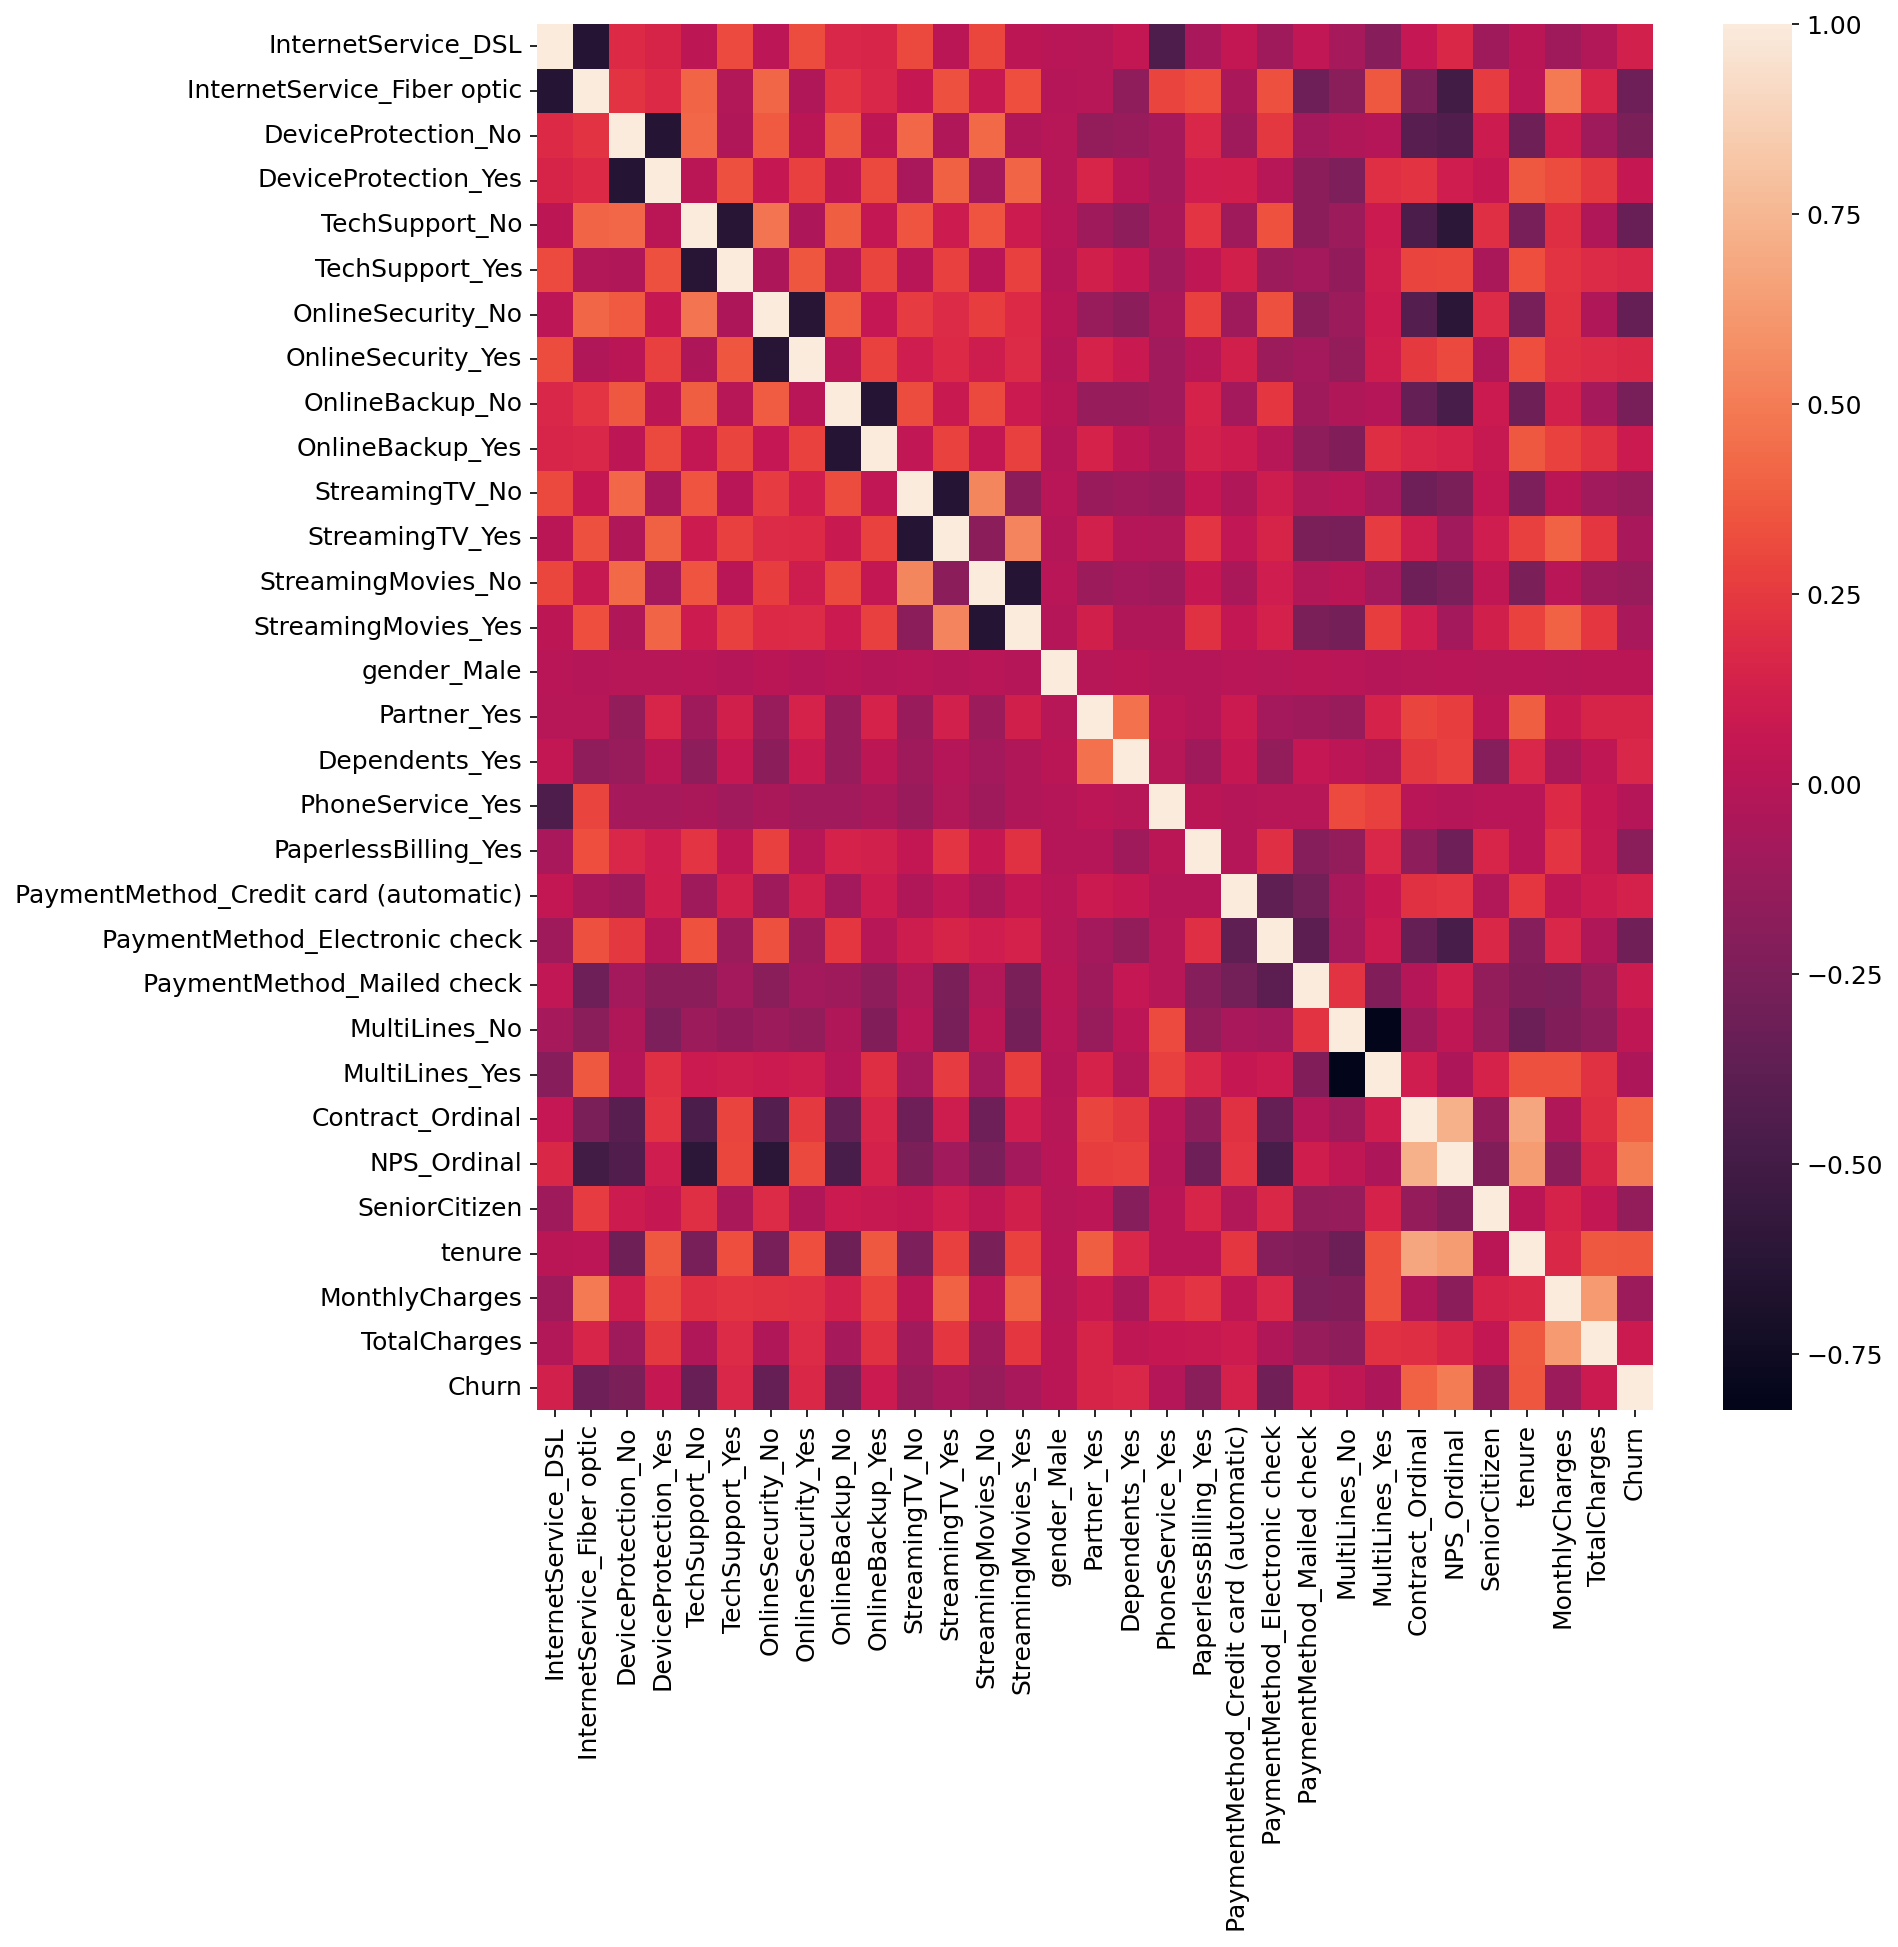

In [23]:
plt.figure(figsize=(12,12))
sns.heatmap(encoded_features.corr())

<Axes: xlabel='None'>

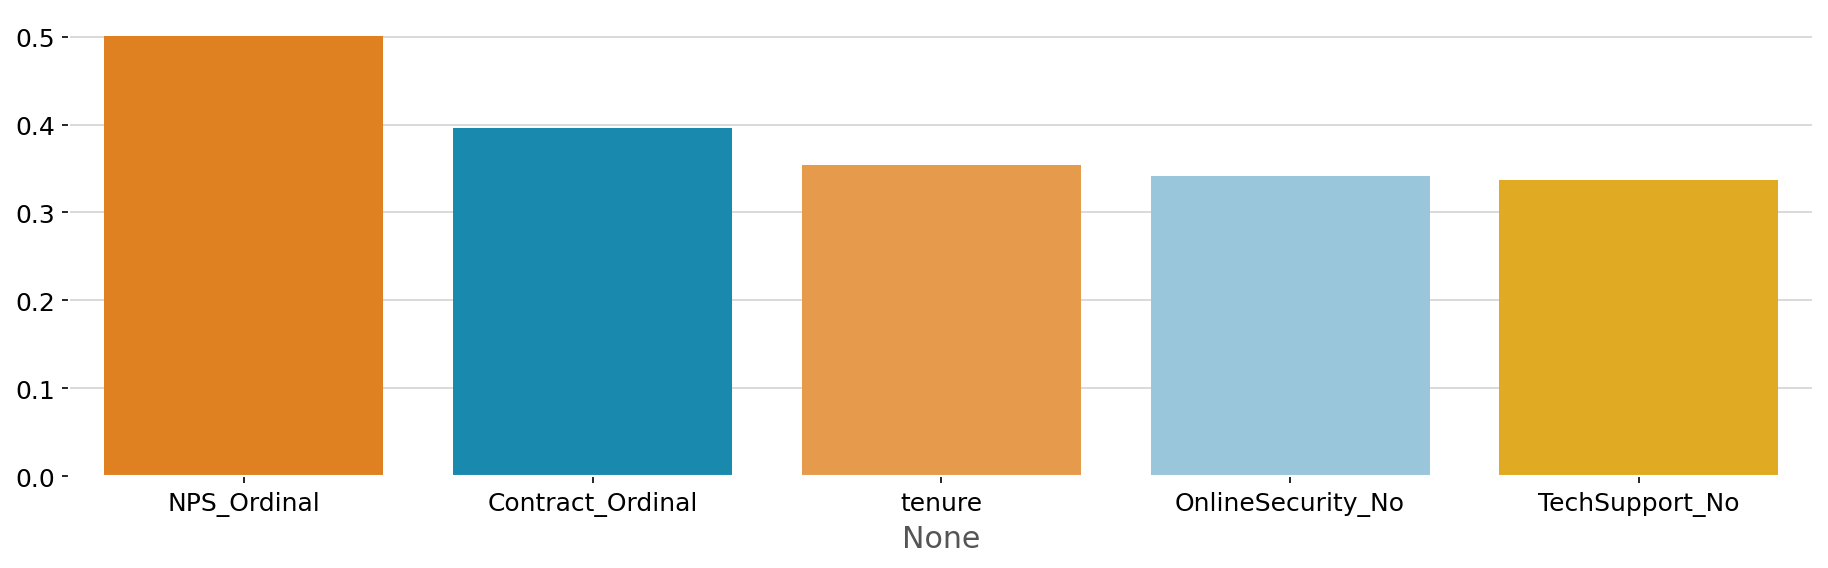

In [24]:
top_corr = abs(encoded_features.corr()['Churn']).sort_values(ascending=False)[1:6]

plt.figure(figsize=(15,4))
sns.barplot(y=top_corr.values,x=top_corr.index,palette=sns.color_palette(['#ff8200', '#0096c7', '#ff9c33', '#8ecae6', '#ffb703']))  

Feature Scalling

In [25]:
sc = StandardScaler()
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']

In [26]:
X_train[['tenure','MonthlyCharges','TotalCharges']] = sc.fit_transform(X_train[['tenure','MonthlyCharges','TotalCharges']])
X_train.head()

,InternetService_DSL,InternetService_Fiber optic,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultiLines_No,MultiLines_Yes,Contract_Ordinal,NPS_Ordinal,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
3028,1,0,0,1,0,1,0,1,0,1,...,0,1,1,0,1,2,0,0.15,0.18,0.02
6274,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,-1.16,-0.98,-0.43
1322,0,1,1,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,-1.12,0.58,-0.36
3050,0,1,1,0,1,0,1,0,1,0,...,1,0,0,1,0,0,0,-1.28,0.18,-0.43
338,0,1,1,0,0,1,0,1,0,1,...,0,0,0,1,2,2,0,1.61,0.85,0.93


Balancing Dataset with SMOTE Technique

In [27]:
smote = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(encoded_features.drop('Churn',axis=1),
                                                    encoded_features['Churn'])

In [28]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [29]:
X_train = sc.fit_transform(X_train)
X_train_smote = sc.fit_transform(X_train_smote)
X_test = sc.transform(X_test)

In [30]:
print('Before SMOTE: {} lines'.format(X_train.shape[0]))
print('After SMOTE: {} lines'.format(X_train_smote.shape[0]))

Before SMOTE: 5298 lines
After SMOTE: 7744 lines


# **Treinamento de modelos, comparação, seleção de features e ajuste de hiperparâmetros.**

### **Criando Modelos**

**Baseline**

O modelo de referência fornecerá métricas comparativas previstas a partir dos dados de uma forma simples;
A técnica de validação cruzada (cross-validate) será utilizada em todos os modelos a serem testados;
A matriz de confusão (confusion matrix) será usada quando testarmos o modelo final com os dados de teste reservados;

In [31]:
base_classifier = DummyClassifier(random_state=1)

In [32]:
baseline = []

# Cross validating the model
cv_result = cross_validate(base_classifier, X_train_smote, y_train_smote, cv=10,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Appending metrics to baseline list
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  baseline.append(cv_result[i].mean())

In [33]:
# Printing the baseline metrics
print(f'Baseline metrics: {baseline}')

Baseline metrics: [np.float64(0.4997419354838709), np.float64(0.09987096774193548), np.float64(0.2), np.float64(0.1332185886402754), np.float64(0.5)]


**Logistic Regression**

In [34]:
classifierLR = LogisticRegression(random_state = 1)

In [35]:
# Creating Logistic Regression list of metrics
logistic_regression = []

# Cross validating the model
cv_result = cross_validate(classifierLR, X_train_smote, y_train_smote, cv=10,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Appending metrics to Logistic Regression list
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  logistic_regression.append(cv_result[i].mean())

In [36]:
logistic_regression

[np.float64(0.813824122697341),
 np.float64(0.8409755659996841),
 np.float64(0.7931211539998401),
 np.float64(0.8126050705080324),
 np.float64(0.9063261228133248)]

**N Nearest Neighbors (KNN)**

In [37]:
classifierKNN = KNeighborsClassifier()

In [38]:
# Creating KNN list of metrics
knn = []

# Cross validating the model
cv_result = cross_validate(classifierKNN, X_train_smote, y_train_smote, cv=10,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Appending metrics to KNN list
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  knn.append(cv_result[i].mean())

In [39]:
# Printing the KNN metrics
knn

[np.float64(0.8182298908060348),
 np.float64(0.8487461590963177),
 np.float64(0.8109359599350009),
 np.float64(0.822527476038702),
 np.float64(0.8951565436545476)]

**Support Vector Machine (SVM)**

In [40]:
classifierSVM = SVC(random_state=0)

In [41]:
# Creating SVM list of metrics
svm = []

# Cross validating the model
cv_result = cross_validate(classifierSVM, X_train_smote, y_train_smote, cv=10,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Appending metrics to SVM list
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  svm.append(cv_result[i].mean())

In [42]:
# Printing the SVM metrics
svm

[np.float64(0.8336015670584311),
 np.float64(0.8556116624406782),
 np.float64(0.844771437704787),
 np.float64(0.8421530981056474),
 np.float64(0.9195564442437231)]

**Naive Bayes**

In [43]:
classifierNB = GaussianNB()

In [44]:
# Creating Gaussian Naive Bayes list of metrics
naive_bayes = []

# Cross validating the model
cv_result = cross_validate(classifierNB, X_train_smote, y_train_smote, cv=10,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Appending metrics to Gaussian Naive Bayes list
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  naive_bayes.append(cv_result[i].mean())

In [45]:
# Printing the Gaussian Naive Bayes metrics
naive_bayes

[np.float64(0.8002550637659416),
 np.float64(0.8340456594126158),
 np.float64(0.7598058019659555),
 np.float64(0.7930941974213997),
 np.float64(0.8683737775762304)]

**Random Forest**

In [46]:
classifierRF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

In [47]:
# Creating Random Forest list of metrics
random_forest = []

# Cross validating the model
cv_result = cross_validate(classifierRF, X_train_smote, y_train_smote, cv=10,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Appending metrics to Random Forest list
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  random_forest.append(cv_result[i].mean())

In [48]:
random_forest

[np.float64(0.8363044094356923),
 np.float64(0.8727733844546182),
 np.float64(0.815593782466235),
 np.float64(0.8375586007313546),
 np.float64(0.9163442259498872)]

**XG Boost**

In [49]:
classifierXGB = XGBClassifier()

In [51]:
# Creating XG Boost list of metrics
XGB = []

# Cross validating the model
cv_result = cross_validate(classifierXGB, X_train_smote, y_train_smote, cv=10,
                            scoring=['accuracy',
                                      'precision',
                                      'recall',
                                      'f1',
                                      'roc_auc'])

# Appending metrics to XG Boost list
for i in ['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']:
  XGB.append(cv_result[i].mean())

In [52]:
# Printing the XG Boost metrics
XGB

[np.float64(0.8403189130615989),
 np.float64(0.8675512583170442),
 np.float64(0.8452835717520445),
 np.float64(0.8482138772572355),
 np.float64(0.9299399511674095)]

### **Classification Models Comparison**

In [53]:
metrics = (pd.DataFrame([baseline,logistic_regression,knn,svm,naive_bayes,random_forest,XGB],
                        index=['Baseline','Logistic Regression', 'KNN', 'SVM', 'Naive Bayes', 'Random Forest','XG Boost'],
                        columns=['Accuracy','Precision','Recall','F1 Score','AUROC'])*100).round(2)

metrics

,Accuracy,Precision,Recall,F1 Score,AUROC
Baseline,49.97,9.99,20.00,13.32,50.00
Logistic Regression,81.38,84.10,79.31,81.26,90.63
KNN,81.82,84.87,81.09,82.25,89.52
SVM,83.36,85.56,84.48,84.22,91.96
Naive Bayes,80.03,83.40,75.98,79.31,86.84
Random Forest,83.63,87.28,81.56,83.76,91.63
XG Boost,84.03,86.76,84.53,84.82,92.99


Para este problema de negócio, o mais importante é prever corretamente os clientes que estão propensos a deixar a empresa (Verdadeiros Positivos) e minimizar o número de pessoas classificadas erroneamente como não propensas a sair (Falsos Negativos).

Por isso, a principal métrica a ser utilizada será o Recall. Não usarei o F1 Score, pois não é tão problemático classificar como 'propensos a sair' os clientes que, na verdade, não vão deixar a empresa (Falsos Positivos).

In [54]:
metrics['Recall'].sort_values(ascending=False)

XG Boost              84.53
SVM                   84.48
Random Forest         81.56
KNN                   81.09
Logistic Regression   79.31
Naive Bayes           75.98
Baseline              20.00
Name: Recall, dtype: float64

**Tuning Logistic Regression Model**

In [55]:
# Tuning XGBoost
tuned_classifierXGB = XGBClassifier(random_state=42)

# Parameters to be used
params_XGB = dict(
    n_estimators = [100, 200, 300],
    max_depth = [3, 5, 7, 9],
    learning_rate = [0.01, 0.1, 0.2],
    subsample = [0.8, 0.9, 1.0],
    colsample_bytree = [0.8, 0.9, 1.0],
    gamma = [0, 0.1, 0.2],
    min_child_weight = [1, 3, 5]
)

gs_XGB = GridSearchCV(estimator=tuned_classifierXGB, 
                      param_grid=params_XGB, 
                      cv=10, 
                      scoring='recall',
                      n_jobs=-1)  # Usar todos os cores disponíveis

# Fitting the model to the training set  
gs_XGB.fit(X_train_smote, y_train_smote)

# Printing the best score acquired from the tuning
best_recall = gs_XGB.best_score_
print("Best Recall Score: {:.2f} %".format(best_recall*100))

# Printing the best parameter found
best_parameters = gs_XGB.best_params_
print("Best Parameters:", best_parameters)

# Making predictions with the best model
y_pred_XGB_tuned = gs_XGB.predict(X_test)

Best Recall Score: 86.31 %
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


**Criando predições**

In [67]:
final_classifier_XGB = XGBClassifier(**best_parameters)

final_classifier_XGB.fit(X_train_smote,y_train_smote)

y_pred_XGB = final_classifier_XGB.predict(X_test)

XGB_corr = confusion_matrix(y_test, y_pred_XGB, normalize='true')

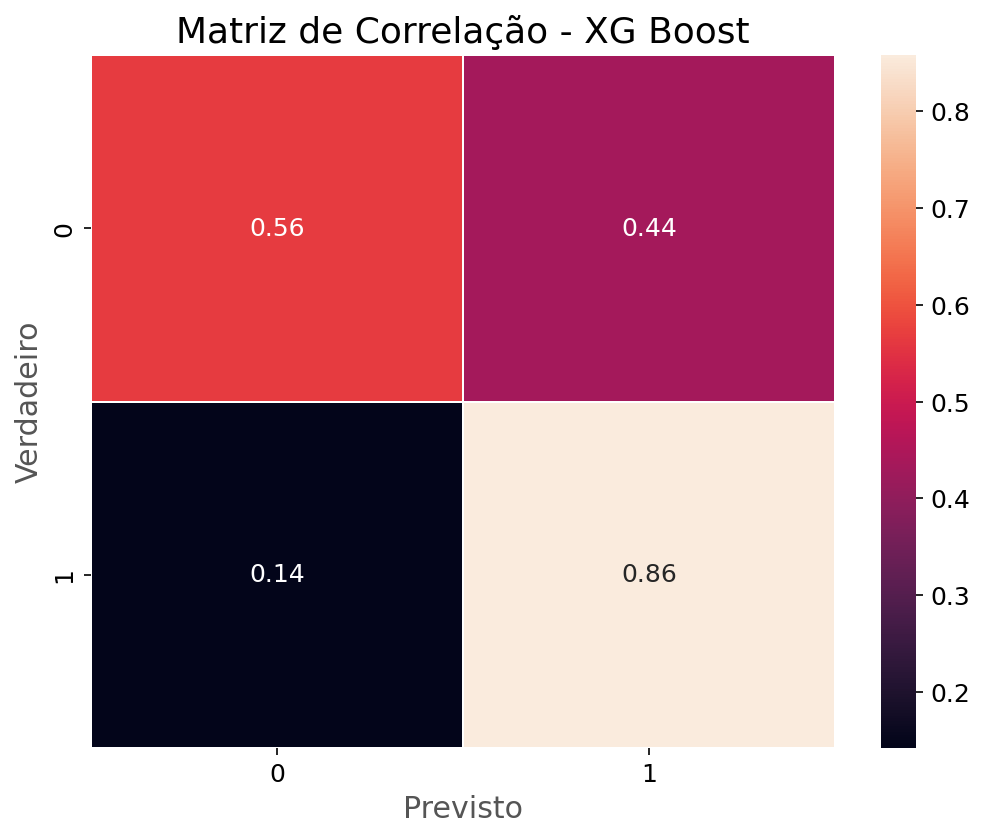

In [58]:
fig, ax = plt.subplots(figsize=(8,6))
plt.title('Matriz de Correlação - XG Boost')

sns.heatmap(XGB_corr, annot=True, linewidths=.1)
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Previsto')

plt.show()

Use of Baseline

In [68]:
base_classifier.fit(X_train_smote,y_train_smote)

y_predBLC = base_classifier.predict(X_test)

blc_corr = confusion_matrix(y_test, y_predBLC, normalize='true')

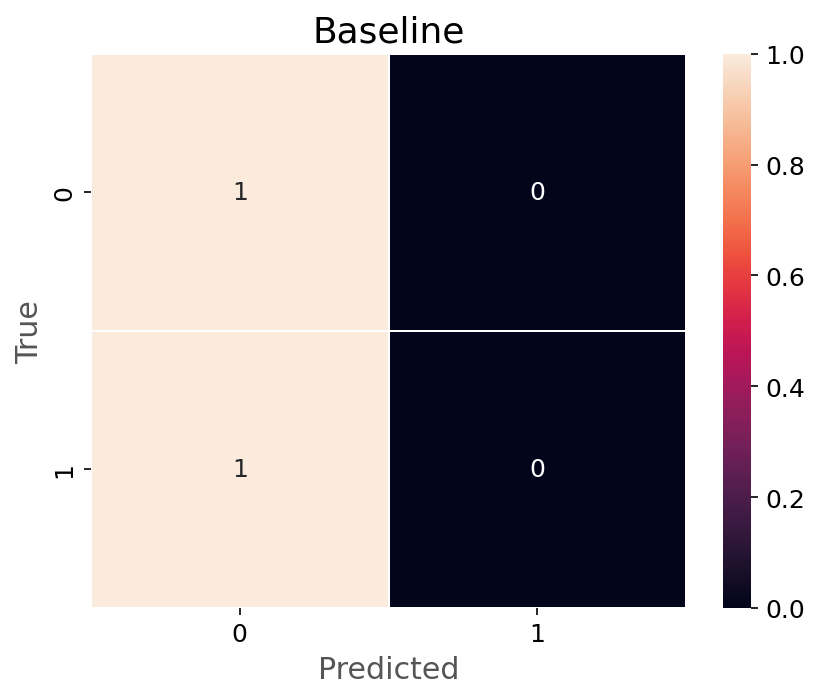

In [60]:
ax = sns.heatmap(blc_corr, annot=True, linewidths=.1)
ax.set_title('Baseline')
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
plt.show()

### **Conclusões**

**Impacto no Business**

In [70]:
print("Revenue last month was R$ {}".format(
    df['MonthlyCharges'].sum()))

Revenue last month was R$ 471242.75


In [72]:
print('The revenue lost in this month due to Churn is R$ {}'.format(
    df[df['Churn']==1]['MonthlyCharges'].sum()))

The revenue lost in this month due to Churn is R$ 329710.69999999995


In [ ]:
print('With our Machine Learning model predicting 0.86% of people who are likely to leave, we would be able to keep in the company R$ {}'.format(round(
    df[df['Churn']==1]['MonthlyCharges'].sum()*0.86,2)))

With our Machine Learning model predicting 0.86% of people who are likely to leave, we would be able to keep in the company R$ 121717.56


In [ ]:
print('With the Baseline model predicting 48% of people who are likely to leave, we would be able to keep in the company R$ {}'.format(round(
    df[df['Churn']==1]['MonthlyCharges'].sum()*0.48,2)))

With the Baseline model predicting 48% of people who are likely to leave, we would be able to keep in the company R$ 67935.38
